<a href="https://colab.research.google.com/github/dannyjammooa/Experimental-Machine-Learning-Projects/blob/master/Bayesian_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Bayesian Analysis of Imqmd Model</center>

### Introduction
$\; \; \; \; \; \;$This jupyter notebook containes my analysis of the Imqmd Model with the experimental data using Bayesian analysis.
In order to do the anylysis certine mathematical tools where used. The mathematical tools that we will be using in this notebook are Preprocessing, Principal Component Analysis(PCA), Gaussian Process, and Markov Chain Monte Carlo (MCMC).

### Librarys
$\; \; \; \; \; \;$ First I will speak about the librarys that were used for this analysis. For this notebook the use of five librarys was crucial, the rest was just to make things prettier for example tqdm.auto to get a loading bar and seaborn for nicer plots.

- NumPy
- Pandas
- Matplotlib/Seaborn
- Scipy.stats
- Scikit Learn

The use of the library NumPy is a given for its use in numerical computation and the use of mathematical funtions. Pandas is used for data manipulation and structuring the data using DataFrames. Matplotlib/Seaborn are used to make graphs of the analysis. Scipy.stats is used for its statistical distributions and PDF of a truncated normal. Scikit learn library will be used to apply Preprocessing to the data, PCA, and Gaussian Processs.


In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from numpy import linalg as la
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel,WhiteKernel,ExpSineSquared
from scipy.stats import norm, uniform, multivariate_normal, truncnorm
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Reading and Scaling Data
$\; \; \; \; \; \;$ In the next portion of the notebook, experimental and Imqmd data will be imported and structured using Pandas. Also the use of scikit learn library for preprocessing will be applied to scale the output data from the Imqmd model. Scaling the data is importent for when PCA and Guassian Process is applied. This process will remove any outliers in the data that might result in big eigenvalues to apear which can effect the use of PCA and thus inturn the Gaussian Process and further anaylsis.

In [0]:
from google.colab import files
uploaded = files.upload()

Saving e120_bugfix_model_new_mv.csv to e120_bugfix_model_new_mv.csv


In [0]:
uploadeds = files.upload()

Saving e120_exp_result.csv to e120_exp_result.csv


In [0]:
import io
features = ['SN112EK42.5', 'SN112EK47.5', 'SN112EK52.5', 'SN112EK57.5', 'SN112EK62.5', 'SN112EK67.5', 'SN112EK72.5', 'SN112EK77.5', 'SN112EK82.5', 'SN112EK87.5', 'SN124EK42.5', 'SN124EK47.5', 'SN124EK52.5', 'SN124EK57.5', 'SN124EK62.5', 'SN124EK67.5', 'SN124EK72.5', 'SN124EK77.5', 'SN124EK82.5', 'SN124EK87.5', 'DREK12.5', 'DREK17.5', 'DREK22.5', 'DREK27.5', 'DREK32.5', 'DREK37.5', 'DREK42.5', 'DREK47.5', 'DREK52.5', 'DREK60.0', 'DREK70.0', 'DREK80.0', 'DREK87.5']
inputs = ['S0', 'L', 'ms', 'mv']
error_features = ['SN112EK42.5_Error', 'SN112EK47.5_Error', 'SN112EK52.5_Error', 'SN112EK57.5_Error', 'SN112EK62.5_Error', 'SN112EK67.5_Error', 'SN112EK72.5_Error', 'SN112EK77.5_Error', 'SN112EK82.5_Error', 'SN112EK87.5_Error', 'SN124EK42.5_Error', 'SN124EK47.5_Error', 'SN124EK52.5_Error', 'SN124EK57.5_Error', 'SN124EK62.5_Error', 'SN124EK67.5_Error', 'SN124EK72.5_Error', 'SN124EK77.5_Error', 'SN124EK82.5_Error', 'SN124EK87.5_Error', 'DREK12.5_Error', 'DREK17.5_Error', 'DREK22.5_Error', 'DREK27.5_Error', 'DREK32.5_Error', 'DREK37.5_Error', 'DREK42.5_Error', 'DREK47.5_Error', 'DREK52.5_Error', 'DREK60.0_Error', 'DREK70.0_Error', 'DREK80.0_Error', 'DREK87.5_Error']
df  = pd.read_csv(io.BytesIO(uploaded['e120_bugfix_model_new_mv.csv']), usecols=features)
df2  = pd.read_csv(io.BytesIO(uploaded['e120_bugfix_model_new_mv.csv']), usecols=inputs)
df3 = pd.read_csv(io.BytesIO(uploadeds['e120_exp_result.csv']), usecols=features)
df4 = pd.read_csv(io.BytesIO(uploadeds['e120_exp_result.csv']), usecols=error_features)

In [0]:
#importing and reshaping experimental data
y_ex_std =df4.loc[:,error_features].values
Y_ex = df3.loc[:, features].values
Y_ex = Y_ex.reshape(1,33)
Y_mu =Y_ex.reshape(33) #used for the likelihood function
y_ex_std = y_ex_std.reshape(33,1)

#importing inputs from imqmd spreadsheet
x = df2.loc[:, inputs].values
xdf = pd.DataFrame(data = x, columns = ['S0', 'L', 'ms', 'mv'])

#importing and scaling output from imqmd spreadsheet
y = df.loc[:, features].values
scaler = StandardScaler(with_std=True, with_mean=False)
CJ = pd.DataFrame(data = y, columns = features)
CJ.head()

,SN112EK42.5,SN112EK47.5,SN112EK52.5,SN112EK57.5,SN112EK62.5,SN112EK67.5,SN112EK72.5,SN112EK77.5,SN112EK82.5,SN112EK87.5,SN124EK42.5,SN124EK47.5,SN124EK52.5,SN124EK57.5,SN124EK62.5,SN124EK67.5,SN124EK72.5,SN124EK77.5,SN124EK82.5,SN124EK87.5,DREK12.5,DREK17.5,DREK22.5,DREK27.5,DREK32.5,DREK37.5,DREK42.5,DREK47.5,DREK52.5,DREK60.0,DREK70.0,DREK80.0,DREK87.5
0,1.049740,1.009370,0.971587,0.933543,0.895236,0.860123,0.828202,0.797841,0.769038,0.742806,1.40493,1.37751,1.35058,1.32147,1.29021,1.25781,1.22430,1.19163,1.15983,1.12686,1.19434,1.21192,1.23344,1.25778,1.28492,1.31206,1.33919,1.36544,1.39081,1.42918,1.47076,1.50127,1.51709
1,1.101460,1.076550,1.053560,1.032650,1.013830,0.995491,0.977648,0.959740,0.941767,0.928342,1.46000,1.46512,1.47600,1.48391,1.48885,1.49423,1.50005,1.51005,1.52425,1.53633,1.17779,1.19134,1.20964,1.23401,1.26444,1.29513,1.32608,1.36158,1.40161,1.45320,1.51812,1.59659,1.65511
2,1.033870,0.999617,0.967117,0.937034,0.909368,0.884840,0.863449,0.842654,0.822455,0.805631,1.37691,1.36034,1.34682,1.33146,1.31428,1.29950,1.28711,1.27224,1.25487,1.24206,1.18462,1.20281,1.22636,1.25178,1.27908,1.30598,1.33249,1.36163,1.39341,1.43365,1.48005,1.51807,1.54192
3,0.979704,0.948603,0.921646,0.900123,0.884032,0.867298,0.849921,0.837539,0.830154,0.821927,1.29187,1.27633,1.26373,1.25524,1.25084,1.24622,1.24137,1.23869,1.23817,1.23582,1.17578,1.19279,1.21577,1.23993,1.26528,1.29176,1.31937,1.34603,1.37173,1.40500,1.44910,1.48531,1.50366
4,1.026250,0.998031,0.974097,0.951106,0.929057,0.908939,0.890750,0.876159,0.865163,0.855486,1.32474,1.31925,1.31962,1.32045,1.32175,1.32643,1.33447,1.34221,1.34966,1.36205,1.17050,1.17938,1.19465,1.21375,1.23669,1.26262,1.29155,1.32245,1.35531,1.40611,1.47931,1.54623,1.59240


### PCA and Gaussian Process
$\; \; \; \; \; \;$ In the next portion of the notebook, the use of PCA and Gaussian Process will be applied. The application of these mathematical tool will be used on the output data form the Imqmd model, for most of the analysis we will be dealing with such data.

#### Principal Component Analysis
$\; \; \; \; \; \;$ If we take a look at the output data from the Imqmd model, we sea that it contains 33 features (or dimensions) with each feature having 47 samples. In order to processed and use the Gaussian Process, one must reduce the size of the output features, for the Gaussian Process would not be able to create an accurte model with such a large dimension size. This is where PCA comes into play, reducing the dimensional space using a best fit.

$\; \; \; \; \; \;$ PCA is an eigenvectore based multivariate analyses. Often, its operation can be thought of as revealing the internal struucture of the data in a way that best explains the variance in the data. Usually the original data is normalized before preforming the PCA, which we have done above with the StandardScaler. If a multivariate dataset is visualised as a set of coordinates in a high-dimensional data spcae, PCA can supply the user with a lower-dimensional picture, a projection of this object when viewed from its most informative viewppoint. PCA calculates the data covariance matrix of the original data and preforms eigenvalue decomposition on the covariance matrix, resulting in the dimensionality of the transformed data to be reduced.

$\; \; \; \; \; \;$ Scikit Learn library for decomposition will be used to preform the PCA calculations. All that is needed for the Scikit Learn PCA package is the data set formated in a design matrix and specifiying the required dimensions for the data set wished to be reduced to. The data set obtained from the PCA calculations will also be scaled to remove any outliers that might effect the predictive model generated by the Gaussian Process.

#### Gaussian Process

$\; \; \; \; \; \;$ Once we have reduced the dimensionality of our data set we can create a predictive model that best represent our data. For the predicitive model, we will use Gaussian Process.

$\; \; \; \; \; \;$ In probability theory and statistics, a Gaussian process is a stochastic process such that every finite collection of random variables has a multivariate normal distribution. The distribution of a Gaussian process is the joint distribution of all  random variables, and as such, it is a distribution over functions with a continuous domain. A machine-learning algorithm that involves a Gaussian process uses lazy learning and a measure of the similarity between points, the kernel function, to predict the value for an unseen point from training data. The prediction is not just an estimate for that point, but also has uncertainty information. Where for an multi-output predictions, multivariate Gaussian processes are used, for which the multivariate Gaussian distribution is the marginal distribution at each point. For some kernel functions, matrix algebra can be used to calculate the predictions and optimisation  is typically used to fit a Gaussian process model.

$\; \; \; \; \; \;$ Scikit Learn library will be used to preform the Gaussian Process calculations and create our predictive model. The Scikit Learn Guassian Process asks for to specifiy the shape of the kernel one whishs to model the data after, and both the input and output data. Then once the gaussian process makes the fit of the model, one can asks for optemization of the kernel length scale for each data set or problem will have its own length scale. Which then one can go back and specifiy the kernel length scale, allowing the Gaussian Process to create a better fit for our predictive model. For this problem we will be using a kernal with the shape of a squared exponential (RBF in this case).

In [0]:
#applying PCA on the scaled outputs and reducing it from 33D to 3D
pca = PCA(n_components=2)
yP = pca.fit_transform(y)
#Once again the data is scaled before going into the Gaussian process
scaler_pca =  StandardScaler(with_std=True, with_mean=False)
scaler_pca = scaler_pca.fit(yP)
yPCA = scaler_pca.transform(yP)
PCADf = pd.DataFrame(data = yPCA, columns = ['PCA 1', 'PCA 2'])

print("Explained variance ratio for each PCA component:",pca.explained_variance_ratio_)
print("Sum of Explained variance ratio:",sum(pca.explained_variance_ratio_))

PCADf.head()

Explained variance ratio for each PCA component: [0.95664316 0.03929512]
Sum of Explained variance ratio: 0.9959382736763225


,PCA 1,PCA 2
0,0.008352,1.706120
1,-1.620604,0.215457
2,-0.317150,0.550783
3,-0.020555,-0.870343
4,-0.582944,-1.002736


In [0]:
#using scikit-learn gaussian process
k1 = ConstantKernel(constant_value=2.07)*RBF(length_scale =[18.3, 89.6, 0.41, 0.394])
k2 = ConstantKernel(constant_value=2.95)*RBF(length_scale =[23.4, 115, 0.301, 0.24])
gp1 = GaussianProcessRegressor(kernel=k1, n_restarts_optimizer=9, normalize_y=True, random_state=0)
gp1.fit(x, yPCA[:,0])
gp2 = GaussianProcessRegressor(kernel=k2, n_restarts_optimizer=9, normalize_y=True, random_state=0)
gp2.fit(x, yPCA[:,1])

print("Kernal 1 optemization:", gp1.kernel_.get_params())
print("-------------------------------------------------------------------------------")
print("Kernal 2 optemization:", gp2.kernel_.get_params())


Kernal 1 optemization: {'k1': 2.07**2, 'k2': RBF(length_scale=[18.3, 89.6, 0.41, 0.394]), 'k1__constant_value': 4.290941187762186, 'k1__constant_value_bounds': (1e-05, 100000.0), 'k2__length_scale': array([18.32135322, 89.64151681,  0.40957352,  0.39375529]), 'k2__length_scale_bounds': (1e-05, 100000.0)}
-------------------------------------------------------------------------------
Kernal 2 optemization: {'k1': 2.95**2, 'k2': RBF(length_scale=[23.4, 115, 0.301, 0.24]), 'k1__constant_value': 8.679872896861689, 'k1__constant_value_bounds': (1e-05, 100000.0), 'k2__length_scale': array([ 23.39601504, 114.90079155,   0.30087252,   0.23979665]), 'k2__length_scale_bounds': (1e-05, 100000.0)}


In [0]:
#predicts new outputs using GP and reverse PCA, while also reversing all the scaling
def gaussian_PCA(S0, L, ms, mv, Samples):
    if Samples > 1:
        S0 = S0.reshape(Samples,1)
        mv = mv.reshape(Samples,1)
        ms = ms.reshape(Samples,1)
        L = L.reshape(Samples,1)
        xx_ = np.concatenate((S0,L),axis=1)
        xxx_ = np.concatenate((ms,mv),axis=1)
        X_ = np.concatenate((xx_,xxx_),axis=1) 
        y1_pred, y1_std = gp1.predict(X_, return_std=True)
        y2_pred, y2_std = gp2.predict(X_, return_std=True)
        y1_pred = y1_pred.reshape(Samples,1)
        y2_pred = y2_pred.reshape(Samples,1)
        y_predz = np.concatenate((y1_pred,y2_pred),axis=1)
        y_preds = scaler_pca.inverse_transform(y_predz)
        return np.dot(y_preds, pca.components_) + pca.mean_
    else:    
        x_ = np.matrix([S0,L,ms,mv]) 
        y1_pred, y1_std = gp1.predict(x_, return_std=True)
        y2_pred, y2_std = gp2.predict(x_, return_std=True)
        y1_pred = y1_pred.reshape(Samples,1)
        y2_pred = y2_pred.reshape(Samples,1)
        y1_std = y1_std.reshape(Samples,1)
        y2_std = y2_std.reshape(Samples,1)
        y_predz = np.concatenate((y1_pred,y2_pred),axis=1)
        y_stdz = np.concatenate((y1_std,y2_std),axis=1)
        y_preds = scaler_pca.inverse_transform(y_predz)
        y_stdk = scaler_pca.inverse_transform(y_stdz)
        y_stds = (y_stdk**2)*np.eye(2)
        return np.dot(y_preds, pca.components_) + pca.mean_, np.dot(np.dot(pca.components_.T,y_stds),pca.components_)

### Bayesian Analysis

$\; \; \; \; \; \;$Bayesian inference is the process of fitting a probability model to a set of data and summarizing the result by a probability distribution on the parameters of the model and on unobserved quantities such as predictions for new observations.

#### Bayes Theorm

Fundamantal rules of statisitcs
- Probability of union of two events X & Y

<center>$P(X \cup Y) = P(X) + P(Y) - P(X \cap Y)$</center>
$\\$
$\\$
<center>for mutually exclusive case</center>
$\\$
$\\$
<center>$P(X \cup Y) = P(X) +P(Y)$ </center>

- Joint Probability
    - given a P(X,Y), using the producte rule we get
    
<center>$P(X,Y) = P(X|Y)P(Y)$</center>

- Marginal Probability
<center>$P(X) = \Sigma_{i}(P(X|Y=i)P(Y=i)$</center>


- Conditional Probability
<center>$P(X|Y) = \frac{P(X,Y)}{P(Y)}$</center>


Using the information above we can formulate
Bayes Theorm:
<center>$P(X|Y) = \frac{P(Y|X)P(X)}{P(Y)}$</center>

P(Y|X) is the likelihood function, and modifies the prior through experimental measurements.

P(X) is the prior distribution, and it represents our state of knowledge about the truth of the hypthiesis (x) before we have analyesed the current data

P(Y) is the evidence, which is a normalization constent.

P(X|Y) is the posterior distribution, it represents our state of knowledge about the truth of the hypothisis in the light of the data

However, for the problem at hand it will be dificult to find the evidence, and thus we will not be using it. So our prosterior we will be using is as follows. 

<center>$P(X|Y) \propto P(Y|X)P(X)$</center></h1>

#### Applying Bayes Theorm to our problem

First we will need to choose/find the priors and likelihood function for the problem.

##### Prior

In this case we have three priors with a uniform distribution and one with a truncated gaussian.

P(S0) $\in$ U[25.7,36] $= \frac{1}{B-A} = \frac{1}{10.3}$

P(L) $\in$ U[32,120] $= \frac{1}{B-A} = \frac{1}{88}$

P(ms) $\in$ N[0.6,1.0] $\neq \frac{1}{\sqrt{2\pi}\sigma}exp(-\sum \frac{(y_{pred} - y_{exp})^2}{2\sigma^2})$, for P(ms) is a truncated normal, so we will use Scipy.Stats truncated normal pdf function to calculate it.

P(mv) $\in$ U[0.6,1.2] $= \frac{1}{B-A} = \frac{1}{0.6}$

##### Likelihood

The likelhood in for this problem is a multivariate guassian.

<center>$Like = \frac{1}{\sqrt{2\pi}\sigma}exp(-\sum \frac{(y_{pred} - y_{exp})^2}{2\sigma^2})$</center>
$\\$
$\\$
<center>$like = \frac{1}{\sqrt{2\pi\left|\Sigma\right|}}e^{(-(y_{pred}-y_{exp})\Sigma^{-1}(y_{pred}-y_{exp}).T)}$</center>
$\\$
$\\$
<center>$\Sigma = Ycov_{pred} + Y_{experror}I$</center>

##### Posterior

Putting everythine togather using Bayes Theorm, we get our posterior distribution.

<center>$P(S0,L,ms,mv|Y) \propto LikeP(S0)P(L)P(ms)P(mv)$</center>

In [0]:
  #finds the PDF of value which has a truncated normal distribution
def trunc_norm_pdf(ms_c):
    return truncnorm.pdf(ms_c, (0.6-0.7)/0.05, (1.0-0.7)/0.05, 0.7, 0.05)

#Generates a value using a truncated normal distribution
def truncated_normal(mean=0.7, sd=0.05, low=0.6, upp=1):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

#creates the likelihood function
def likelihoodFunc(Y, mean, cov):
    return multivariate_normal.pdf(Y, mean, cov)

#created the likeihood function
def PosteriorFunc(S0,L,ms,mv):
    r = gaussian_PCA(S0,L,ms,mv,Samples=1)
    Y = r[0]
    covM = r[1]
    COVMM = covM + (y_ex_std**2)*np.eye(33)
    like = likelihoodFunc(Y,Y_mu,COVMM)
    ms_prior = trunc_norm_pdf(ms) 
    return like*(1/10.3)*(1/88)*(ms_prior)*(1/0.6)

### Markov Chain Monte Carlo

$\; \; \; \; \; \;$Markov chain Monte Carlo methods create samples from a continuous random variable, with probability density proportional to a known function. These samples can be used to evaluate an integral over that variable, as its expected value or variance. Practically, an ensemble of chains is generally developed, starting from a set of points arbitrarily chosen and sufficiently distant from each other. These chains are stochastic processes of "walkers" which move around randomly according to an algorithm that looks for places with a reasonably high contribution to the integral to move into next, assigning them higher probabilities.

$\; \; \; \; \; \;$Random walk Monte Carlo methods are a kind of random simulation or Monte Carlo method. However, whereas the random samples of the integrand used in a conventional Monte Carlo integration are statistically independent, those used in MCMC are autocorrelated. Correlations of samples introduces the need to use the Markov chain central limit theorem when estimating the error of mean values. These algorithms create Markov chains such that they have an equilibrium distribution which is proportional to the function given.

#### Metropolis-Hastings Algorithm

$\; \; \; \; \; \;$The algorith that will be used to look for places with a reasonably high contribution to the integral to move into next in this notebook is the Metropilis-Hastings Alogrithm.

Say we are sampling f(x)

1. we choose an arbitrary point $x_{t}$ to be the first sample
2. we generate a candidate x' based on the previous sample by moving to the right or left. (x -> x')
3. we create the acceptance ratio $\alpha = \frac{f(x')}{f(x)}$.
    
    Accept or reject:
    - Generate a uniform random number u  $\in$   [0,1]

    - if $u \leq min(1,\alpha)$, then accept the candidate by setting $x_{t+1} = x'$

    - if $u>  min(1,\alpha)$, then reject the candidate and set $x_{t+1} = x_{t}$
    


In [0]:
#Method 2 puts parameters over S0, L, ms, and mv
def MCMC(PosteriorFunc, Iterations, step1, step2, step3, step4):
    ms_a = []
    mv_a = []
    L_a = []
    S0_a = []
    a_a = []
    p_a = []
    a_c = 0
    ms_c = 0.7
    mv_c = 0.7
    L_c = 60
    S0_c = 26
    posterior_c =PosteriorFunc(S0_c,L_c,ms_c,mv_c)
    for event in tqdm(range(Iterations-1)):
        ms_p = ms_c + np.random.uniform(-step3,step3)
        mv_p = mv_c + np.random.uniform(-step4,step4)
        L_p = L_c + np.random.uniform(-step2,step2)
        S0_p = S0_c + np.random.uniform(-step1,step1)
        parameters = [0.6<=ms_p<=1.0,0.6<=mv_p<=1.2,25.7<=S0_p<=36,32<=L_p<=120]
        if all(parameters): 
            posterior_p = PosteriorFunc(S0_p,L_p,ms_p,mv_p)
            met_r = posterior_p/posterior_c
            accept = np.random.rand() < min(1,met_r)
            if accept:
                ms_c = ms_p
                mv_c = mv_p
                S0_c = S0_p
                L_c = L_p
                posterior_c = posterior_p
                a_c = a_c + 1
                p_a.append(posterior_c)
                a_a.append(a_c)
                ms_a.append(ms_c)
                mv_a.append(mv_c)
                L_a.append(L_c)
                S0_a.append(S0_c)
    return np.array(ms_a), np.array(mv_a),np.array(L_a),np.array(S0_a), np.array(a_a), np.array(p_a)

def MCMC2(PosteriorFunc, Iterations, step1, step2, step3, step4):
    ms_a = []
    mv_a = []
    L_a = []
    S0_a = []
    p_a = []
    a_a = []
    a_c = 0
    ms_c = 0.7
    mv_c = 0.7
    L_c = 60
    S0_c = 28
    posterior_c =PosteriorFunc(S0_c,L_c,ms_c,mv_c)
    for event in tqdm(range(Iterations-1)):
        ms_p = ms_c + np.random.uniform(-step3,step3)
        mv_p = mv_c + np.random.uniform(-step4,step4)
        L_p = L_c + np.random.uniform(-step2,step2)
        S0_p = S0_c + np.random.uniform(-step1,step1)
        parameters = [0.6<=mv_p<=1.2,25.7<=S0_p<=36,32<=L_p<=120]
        if all(parameters): 
            posterior_p = PosteriorFunc(S0_p,L_p,ms_p,mv_p)
            accept = np.random.rand() < posterior_p/posterior_c
            if accept:
                ms_c = ms_p
                mv_c = mv_p
                S0_c = S0_p
                L_c = L_p
                a_c = a_c + 1
                posterior_c = posterior_p
                ms_a.append(ms_c)
                mv_a.append(mv_c)
                L_a.append(L_c)
                S0_a.append(S0_c)
                a_a.append(a_c)
                p_a.append(posterior_c)
            else:
                ms_c = ms_c
                mv_c = mv_c
                S0_c = S0_c
                L_c = L_c
                posterior_c = posterior_c
                ms_a.append(ms_c)
                mv_a.append(mv_c)
                L_a.append(L_c)
                S0_a.append(S0_c)
                p_a.append(posterior_c)
        else:
            ms_c = ms_c
            mv_c = mv_c
            S0_c = S0_c
            L_c = L_c
            posterior_c = posterior_c
            ms_a.append(ms_c)
            mv_a.append(mv_c)
            L_a.append(L_c)
            S0_a.append(S0_c)
            p_a.append(posterior_c)
    return np.array(ms_a), np.array(mv_a),np.array(L_a),np.array(S0_a), np.array(a_a), np.array(p_a)

#gives the weighted average and std of the inputs S0,L,ms,mv after MCMC sampling
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

### Analysis

$\; \; \; \; \; \;$ We will be using the sampled S0, L, ms, and mv for our analysis. The sampled variables are not the posterior distribution, however they have been influnced by it and thus takes a similar shape to it. The posterior distribution will be used to attain the average and std of each sampled variable.


acceptace rate: 0.4701698


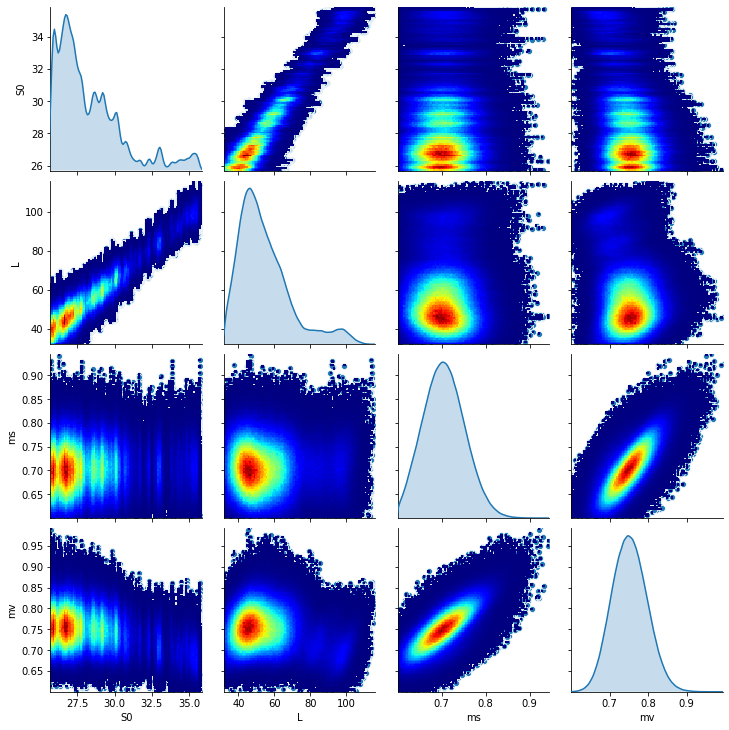

In [0]:
#Runs the MCMC sampling
N= 5000000
Bayesian = MCMC(PosteriorFunc,Iterations=N ,step1=0.01, step2=1, step3=0.03, step4=0.03) #calling the MCMC methods

#Get the Sampled data from the MCMC
kms = Bayesian[0]
kmv = Bayesian[1]
kL = Bayesian[2]
kS0 = Bayesian[3]
ka = Bayesian[4]
kp = Bayesian[5]

#The acceptance rate of the metropilis algrothem
accept = kms.size
GG = ka.size/N
print("acceptace rate:", GG)

#reshaping the data for analysis
kS0 = kS0.reshape(accept,1)
kL = kL.reshape(accept,1)
kms = kms.reshape(accept,1)
kmv = kmv.reshape(accept,1)
kp = kp.reshape(accept,1)
SL = np.concatenate((kS0,kL),axis=1)
msv = np.concatenate((kms,kmv),axis=1)
x_mcmc = np.concatenate((SL,msv),axis=1)
x_MCMC = pd.DataFrame(data = x_mcmc, columns =  ['S0', 'L', 'ms', 'mv'])

#creates figure 2
T = sns.pairplot(x_MCMC, diag_kind="kde")
T.map_offdiag(plt.hist2d, bins=100, edgecolor=None, cmin=1,cmap=plt.cm.jet)
#T = sns.pairplot(x_MCMC,plot_kws=dict(edgecolor="k", linewidth=0.5),diag_kind="kde")

In [0]:
#Find the weighted average and std of each input after mcmc sampling
mean_S0, std_S0 = weighted_avg_and_std(kS0, kp)
mean_L, std_L = weighted_avg_and_std(kL, kp)
mean_ms, std_ms = weighted_avg_and_std(kms, kp)
mean_mv, std_mv = weighted_avg_and_std(kmv, kp)
print("S0:", "mean:", mean_S0, "std:", std_S0)
print("L:", "mean:", mean_L, "std:", std_L)
print("ms:", "mean:", mean_ms, "std:", std_ms)
print("mv:", "mean:", mean_mv, "std:", std_mv)

S0: mean: 28.441526738910287 std: 2.2315706710180394
L: mean: 55.24908279876195 std: 14.312264513730494
ms: mean: 0.704894898626691 std: 0.03390561354105348
mv: mean: 0.74809684559232 std: 0.0344686920450471


(-0.4, 0.4)

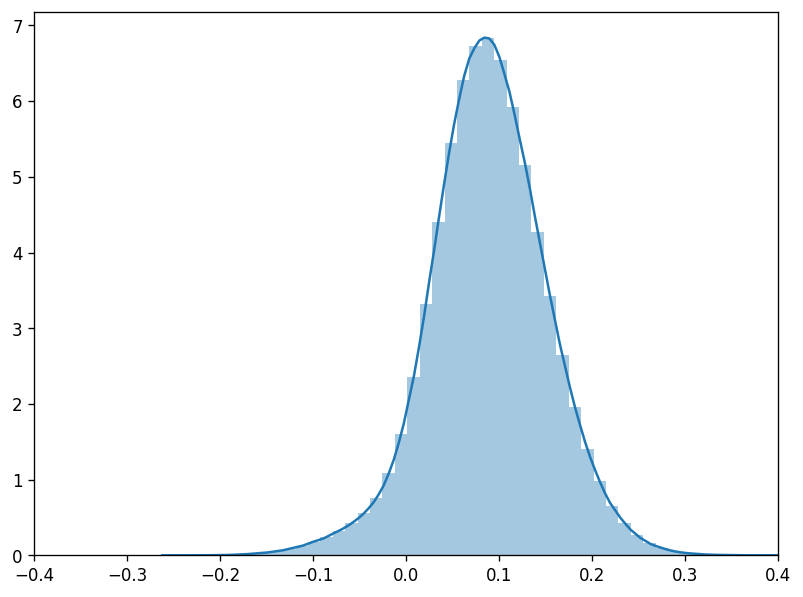

In [0]:
#using the ms and mv sampling from mcmc, figure 3 can be created
fI = 1/kms - 1/kmv
figure(num=None,figsize=(8,6), dpi=120, facecolor='w', edgecolor='k')
sns.distplot(fI)
plt.xlim(-0.4,0.4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


(0.4, 1.8)

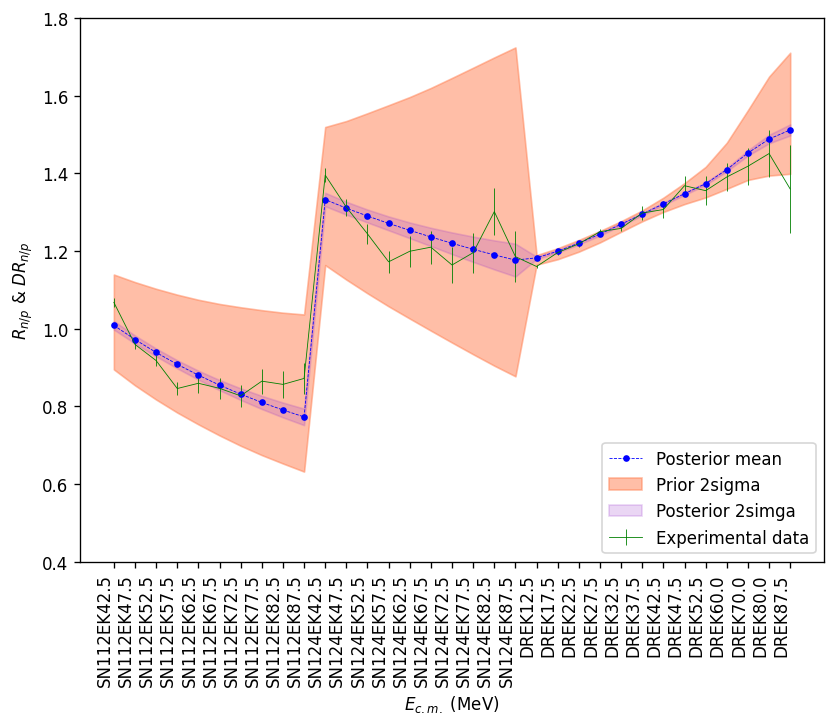

In [0]:
#creating the 2sigma prior in figure 1
Samples = 500 
mms = truncated_normal(mean =0.7, sd =0.05, low=0.6, upp=1) 
mms = mms.rvs(Samples)
mmv = np.random.uniform(0.6,1.2,Samples) 
sS0 = np.random.uniform(25.7,36,Samples)
lL = np.random.uniform(32,120,Samples) 

y_prior = gaussian_PCA(sS0,lL,mms,mmv,Samples)
y_prior_preddf = pd.DataFrame(data = y_prior, columns =  features)
y_prior_preddf.head()

#finding the mean and std of each feature
y_prior_mean = y_prior_preddf[features].mean()
sig =  np.std(y_prior_preddf[features])
sig = 2*sig

"--------------------------------------------------------------------"

y_ex_stds = y_ex_std.reshape(33,1)
Y_exs = Y_ex.reshape(33,1)

"---------------------------------------------------------------------"
#mcmc posterior mean
Y_mcmc = gaussian_PCA(kS0,kL,kms,kmv,accept)
Y_mcmcdf= pd.DataFrame(data = Y_mcmc, columns =  features)
Y_mcmcdf.head()

Y_mcmc_mean = Y_mcmcdf[features].mean()
sigma_mcmc =  np.std(Y_mcmcdf[features])
sigma_mcmc = 2*sigma_mcmc


figure(num=None,figsize=(8,6), dpi=120, facecolor='w', edgecolor='k')
#here figure 1 is created
Y_ex = Y_ex.reshape(33,1)
exp_data = plt.errorbar(features,Y_exs, yerr = y_ex_stds, fmt ='g',linewidth=0.5, label ='Experimental data')
two_sigma = plt.fill_between(features, y_prior_mean + sig,y_prior_mean -sig, alpha=0.5, color='coral', label='Prior 2sigma')
RRE = plt.plot(features, Y_mcmc_mean, 'b.--',linewidth=0.5, label ='Posterior mean')
UY = plt.fill_between(features, Y_mcmc_mean + sigma_mcmc,Y_mcmc_mean-sigma_mcmc, alpha=0.2, color='darkorchid', label='Posterior 2simga')
plt.xlabel('$E_{c.m.}$ (MeV)')
plt.xticks(rotation=90, ha='right')
plt.ylabel('$R_{n/p}$ & $DR_{n/p}$')
plt.legend([exp_data,two_sigma],['exp_data','two_sigma'])
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.legend(loc='lower right')
plt.ylim(0.4,1.8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


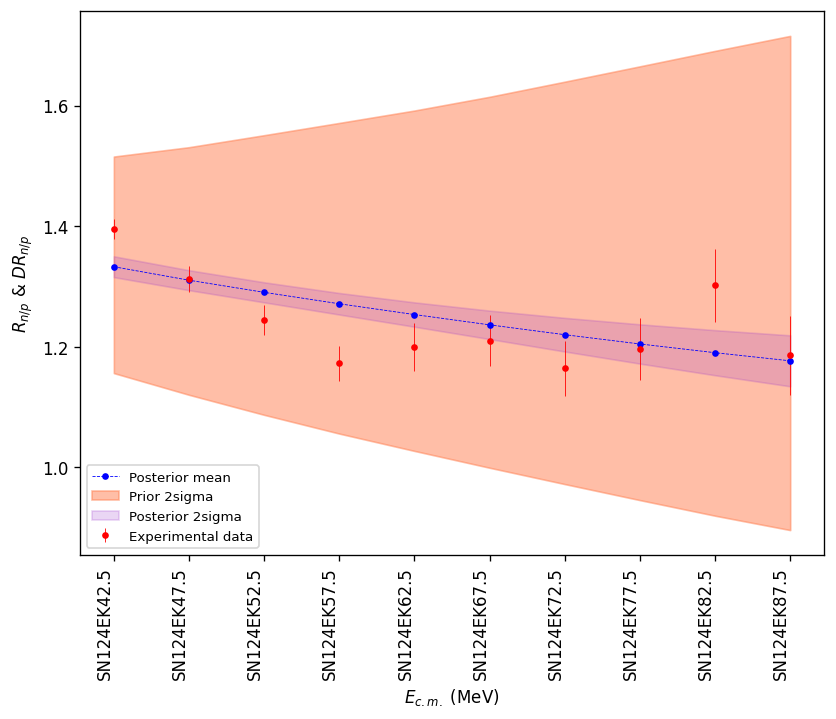

In [0]:
Z = np.array( [1.335803,1.325567,1.318902,1.313525, 1.309430,1.306878, 1.305863,1.305298,1.305183,1.305689])
Zs = np.array([0.179565,0.205310,0.231871,0.257589,0.282239,0.307595,0.333665,0.359684,0.385428,0.409760])
ZX = np.array(['SN124EK42.5', 'SN124EK47.5', 'SN124EK52.5', 'SN124EK57.5', 'SN124EK62.5', 'SN124EK67.5', 'SN124EK72.5', 'SN124EK77.5', 'SN124EK82.5', 'SN124EK87.5'])


SN124 = ['SN124EK42.5', 'SN124EK47.5', 'SN124EK52.5', 'SN124EK57.5', 'SN124EK62.5', 'SN124EK67.5', 'SN124EK72.5', 'SN124EK77.5', 'SN124EK82.5', 'SN124EK87.5']
error_124 = [ 'SN124EK42.5_Error', 'SN124EK47.5_Error', 'SN124EK52.5_Error', 'SN124EK57.5_Error', 'SN124EK62.5_Error', 'SN124EK67.5_Error', 'SN124EK72.5_Error', 'SN124EK77.5_Error', 'SN124EK82.5_Error', 'SN124EK87.5_Error']
y_124_std =df4.loc[:,error_124].values
Y_124 = df3.loc[:,SN124].values
y_124_std = y_124_std.reshape(10,1)
Y_124 = Y_124.reshape(10,1)


Y_124_mean = Y_mcmcdf[SN124].mean()
sigma_124 =  np.std(Y_mcmcdf[SN124])
sigma_124 = 2*sigma_124

figure(num=None,figsize=(8,6), dpi=120, facecolor='w', edgecolor='k')
exp_data = plt.errorbar(SN124,Y_124, yerr = y_124_std, fmt ='r.',linewidth=0.5, label ='Experimental data')
plt.fill_between(ZX, Z+Zs,Z-Zs, alpha=0.5, color='coral', label = 'Prior 2sigma')
plt.plot(SN124, Y_124_mean, 'b.--',linewidth=0.5, label ='Posterior mean')
plt.fill_between(SN124, Y_124_mean + sigma_124, Y_124_mean-sigma_124, alpha=0.2, color='darkorchid', label='Posterior 2sigma')
plt.xlabel('$E_{c.m.}$ (MeV)')
plt.xticks(rotation=90, ha='right')
plt.ylabel('$R_{n/p}$ & $DR_{n/p}$')
plt.legend(loc='lower left', prop={'size': 8})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


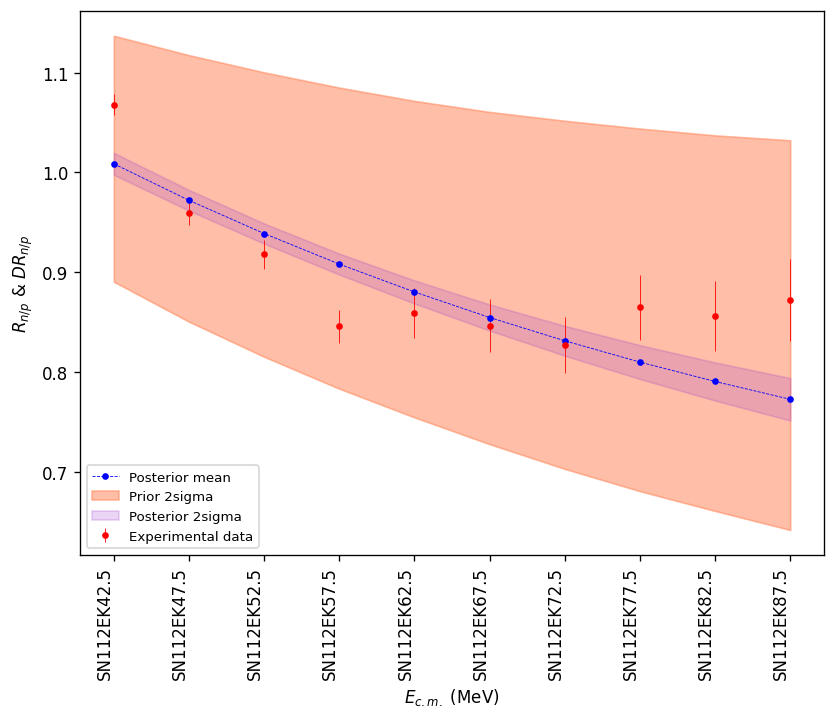

In [0]:
Z1s = np.array([0.123179,0.133487,0.142444,0.150812,0.158498,0.166378,0.174346,0.181592,0.188096, 0.195155])
Z1 = np.array([1.013725, 0.984022,0.957827,0.934212,0.913177,0.894256,0.877451,0.862392,0.849078,0.837098])
Z1X = np.array(['SN112EK42.5', 'SN112EK47.5', 'SN112EK52.5', 'SN112EK57.5', 'SN112EK62.5', 'SN112EK67.5', 'SN112EK72.5', 'SN112EK77.5', 'SN112EK82.5', 'SN112EK87.5'])


SN112 = ['SN112EK42.5', 'SN112EK47.5', 'SN112EK52.5', 'SN112EK57.5', 'SN112EK62.5', 'SN112EK67.5', 'SN112EK72.5', 'SN112EK77.5', 'SN112EK82.5', 'SN112EK87.5']
error_112 = ['SN112EK42.5_Error', 'SN112EK47.5_Error', 'SN112EK52.5_Error', 'SN112EK57.5_Error', 'SN112EK62.5_Error', 'SN112EK67.5_Error', 'SN112EK72.5_Error', 'SN112EK77.5_Error', 'SN112EK82.5_Error', 'SN112EK87.5_Error']
y_112_std =df4.loc[:,error_112].values
Y_112 = df3.loc[:,SN112].values
y_112_std = y_112_std.reshape(10,1)
Y_112 = Y_112.reshape(10,1)


Y_112_mean = Y_mcmcdf[SN112].mean()
sigma_112 =  np.std(Y_mcmcdf[SN112])
sigma_112 = 2*sigma_112

figure(num=None,figsize=(8,6), dpi=120, facecolor='w', edgecolor='k')
exp_data = plt.errorbar(SN112,Y_112, yerr = y_112_std, fmt ='r.',linewidth=0.5, label ='Experimental data')
plt.fill_between(Z1X, Z1+Z1s,Z1-Z1s, alpha=0.5, color='coral', label='Prior 2sigma')
plt.plot(SN112, Y_112_mean, 'b.--',linewidth=0.5, label ='Posterior mean')
plt.fill_between(SN112, Y_112_mean + sigma_112, Y_112_mean-sigma_112, alpha=0.2, color='darkorchid', label='Posterior 2sigma')
plt.xlabel('$E_{c.m.}$ (MeV)')
plt.xticks(rotation=90, ha='right')
plt.ylabel('$R_{n/p}$ & $DR_{n/p}$')
plt.legend(loc='lower left',prop={'size': 8})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


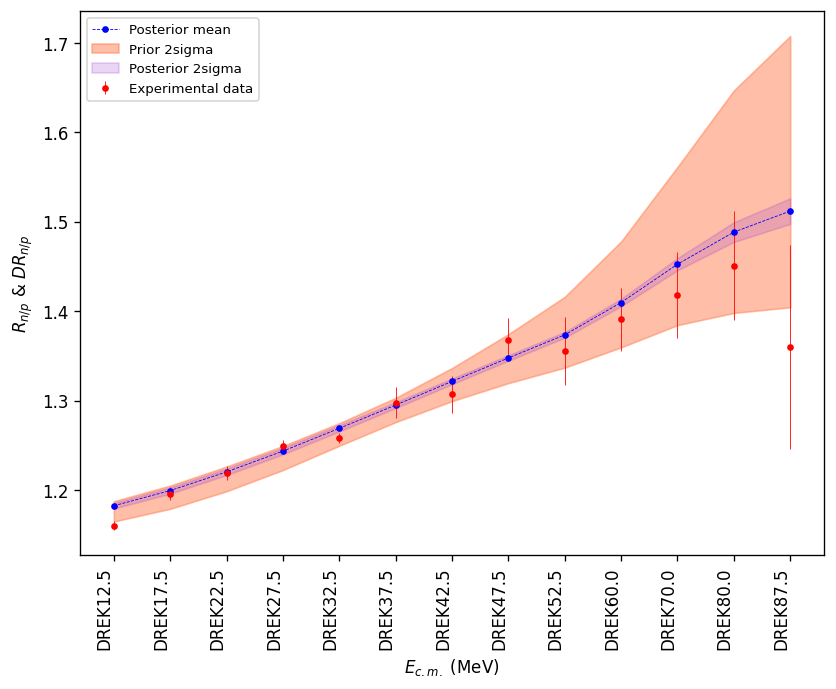

In [0]:
Z3s = np.array([0.011351,0.012962,0.013776,0.013446,0.012633,0.013557,0.018491,0.027344,0.039574,0.059170,0.088390,0.124327,0.151618])
Z3 = np.array([1.176231,1.192064,1.212508,1.235886,1.262202,1.289569,1.317988,1.346957,1.376477,1.418765,1.472804,1.522410,1.555987])
Z3X = np.array(['DREK12.5', 'DREK17.5', 'DREK22.5', 'DREK27.5', 'DREK32.5', 'DREK37.5', 'DREK42.5', 'DREK47.5', 'DREK52.5', 'DREK60.0', 'DREK70.0', 'DREK80.0', 'DREK87.5'])


SNDR = ['DREK12.5', 'DREK17.5', 'DREK22.5', 'DREK27.5', 'DREK32.5', 'DREK37.5', 'DREK42.5', 'DREK47.5', 'DREK52.5', 'DREK60.0', 'DREK70.0', 'DREK80.0', 'DREK87.5']
error_DR = ['DREK12.5_Error', 'DREK17.5_Error', 'DREK22.5_Error', 'DREK27.5_Error', 'DREK32.5_Error', 'DREK37.5_Error', 'DREK42.5_Error', 'DREK47.5_Error', 'DREK52.5_Error', 'DREK60.0_Error', 'DREK70.0_Error', 'DREK80.0_Error', 'DREK87.5_Error']
y_DR_std =df4.loc[:,error_DR].values
Y_DR = df3.loc[:,SNDR].values
y_DR_std = y_DR_std.reshape(13,1)
Y_DR = Y_DR.reshape(13,1)


Y_DR_mean = Y_mcmcdf[SNDR].mean()
sigma_DR =  np.std(Y_mcmcdf[SNDR])
sigma_DR= 2*sigma_DR

figure(num=None,figsize=(8,6), dpi=120, facecolor='w', edgecolor='k')
exp_data = plt.errorbar(SNDR,Y_DR, yerr = y_DR_std, fmt ='r.',linewidth=0.5, label ='Experimental data')
plt.fill_between(Z3X, Z3+Z3s,Z3-Z3s, alpha=0.5, color='coral', label='Prior 2sigma')
plt.plot(SNDR, Y_DR_mean, 'b.--',linewidth=0.5, label ='Posterior mean')
plt.fill_between(SNDR, Y_DR_mean + sigma_DR, Y_DR_mean-sigma_DR, alpha=0.2, color='darkorchid', label='Posterior 2sigma')
plt.xlabel('$E_{c.m.}$ (MeV)')
plt.xticks(rotation=90, ha='right')
plt.ylabel('$R_{n/p}$ & $DR_{n/p}$')
plt.legend(loc='upper left', prop={'size': 8})